In [61]:
#Dependencies
import pathlib
import SimpleITK as sitk
import numpy as np

from transforms import array_transforms
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

Read Image and get sitk and np 

In [62]:
image_path = pathlib.Path(r"C:/Users/Konstantinos/Desktop/Spider Data/train_image_slices/2_t1_17.mha")
label_path = pathlib.Path(r"C:/Users/Konstantinos/Desktop/Spider Data/train_label_slices/2_t1_17.mha")

image_sitk = sitk.ReadImage(image_path)
label_sitk = sitk.ReadImage(label_path)

image_np = sitk.GetArrayFromImage(image_sitk)
label_np = sitk.GetArrayFromImage(label_sitk)

print(image_np.shape)
print(label_np.shape)

(436, 433)
(436, 433)


Get dims for bounding box

In [63]:
# Find the bounding box of the ROI in the label array
rows = np.any(label_np, axis=1)
cols = np.any(label_np, axis=0)

rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]

# Calculate the dimensions of the ROI
roi_height = rmax - rmin + 1
roi_width = cmax - cmin + 1

# Ensure the dimensions are multiples of 16 for U-Net
if roi_height % 16 != 0:
    out_row = ((roi_height + 15) // 16) * 16
else:
    out_row = roi_height

if roi_width % 16 != 0:
    out_col = ((roi_width + 15) // 16) * 16
else:
    out_col = roi_width

 # Calculate the center of the bounding box
center_row = (rmin + rmax) // 2
center_col = (cmin + cmax) // 2

# Calculate the crop start coordinates
start_row = max(0, center_row - out_row // 2)
start_col = max(0, center_col - out_col // 2)

# Ensure the crop stays within the image boundaries
end_row = min(start_row + out_row, image_np.shape[0])
end_col = min(start_col + out_col, image_np.shape[1])
start_row = end_row - out_row
start_col = end_col - out_col

print("row idx start", start_row)
print("col idx start ", start_col)
print("row idx end", end_row)
print("col end idx", end_col)


row idx start 0
col idx start  135
row idx end 368
col end idx 295


Convert the image to RGB and draw lines to show where bounding box on both label and image

In [64]:
def convert_hu_to_rgb(image_np, window_center=None, window_width=None, colormap_name='gray', is_label=False):
    # Ensure the input is a NumPy array
    if not isinstance(image_np, np.ndarray):
        raise TypeError("Input image must be a NumPy array.")
    
    if is_label:
        # If the image is a label, expand the single-channel image into 3 channels (RGB)
        rgb_image = np.stack([image_np] * 3, axis=-1).astype(np.uint8)
        
    else:
        # Determine default window center and width if not provided
        if window_center is None:
            window_center = np.mean(image_np)
        if window_width is None:
            window_width = np.max(image_np) - np.min(image_np)
        
        # Windowing: convert HU to grayscale
        min_value = window_center - window_width // 2
        max_value = window_center + window_width // 2
        image_np = np.clip(image_np, min_value, max_value)
        image_np = (image_np - min_value) / (max_value - min_value) * 255.0
        image_np = image_np.astype(np.uint8)

        # Apply colormap
        cmap = get_cmap(colormap_name)
        rgb_image = cmap(image_np)

        # Convert to 8-bit RGB
        rgb_image = (rgb_image[:, :, :3] * 255).astype(np.uint8)

    return rgb_image

Convert the images to RGB to plot lines where crop

C:\Users\Konstantinos\AppData\Local\Temp\ipykernel_7112\4185821475.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(colormap_name)


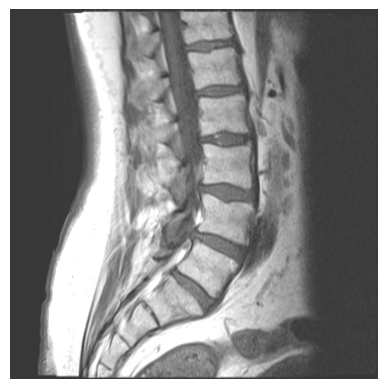

In [65]:
image_rgb = convert_hu_to_rgb(image_np, is_label=False)
label_rgb = convert_hu_to_rgb(label_np, is_label=True)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

Plot the lines and show

In [66]:

def draw_red_lines(image, row_coords, col_coords, thickness=1):
    """
    Draws red lines on a copy of the input image at specified row and column coordinates with specified thickness.
    
    Parameters:
    - image: NumPy array of the input image (RGB).
    - row_coords: List or array of row coordinates where horizontal lines should be drawn.
    - col_coords: List or array of column coordinates where vertical lines should be drawn.
    - thickness: Thickness of the lines.
    
    Returns:
    - A copy of the image with red lines drawn.
    """
    # Make a copy of the image to avoid modifying the original
    image_copy = np.copy(image)
    
    # Draw red lines on the copy
    for row in row_coords:
        # Ensure row index is within the image bounds
        if 0 <= row < image_copy.shape[0]:
            start = max(0, row - thickness // 2)
            end = min(image_copy.shape[0], row + thickness // 2 + 1)
            image_copy[start:end, :, :] = [255, 0, 0]  # Red color
    
    for col in col_coords:
        # Ensure column index is within the image bounds
        if 0 <= col < image_copy.shape[1]:
            start = max(0, col - thickness // 2)
            end = min(image_copy.shape[1], col + thickness // 2 + 1)
            image_copy[:, start:end, :] = [255, 0, 0]  # Red color
    
    return image_copy

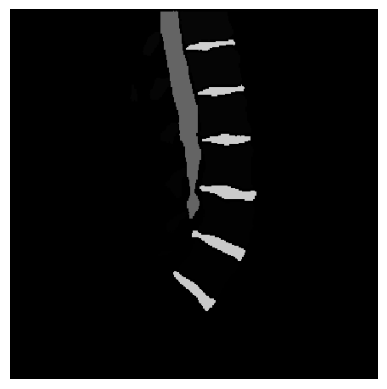

In [67]:
image_rgb_lines = draw_red_lines(image_rgb, [start_row, end_row], [start_col, end_col], thickness= 3)
label_rgb_lines = draw_red_lines(label_rgb, [start_row, end_row], [start_col, end_col], thickness= 3)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(label_rgb)

plt.show()
